# LOAD USEFUL LIBRARIES

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, save, load
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from sklearn.metrics import precision_score, recall_score, fbeta_score
from tabulate import tabulate
import copy


# DEVICE CONFIGURATION

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DEFINE GLOBAL VARIABLES

In [48]:
#NETWORKS SIZES
Input_Size_1= 48
Hidden_Size_1=40
Output_Size_1=48
Input_Size_2= 48


# pre-training and hyperparamentes
learning_rate = 0.4
n_epochs_pre = 60
momentum=0.5
temperature=1.0
patterns_number_pre=80


#GRAPHIC OF PRETRAINING
epoch_list = list(range(1, n_epochs_pre + 1))
epoch_1_order= np.zeros(n_epochs_pre)
epoch_2_order= np.zeros(n_epochs_pre)
patterns_matrix= np.zeros((n_epochs_pre, patterns_number_pre))


colors = [
    'b', 'g', 'r', 'c', 'm', 'y', 'k',
    '#FF5733', '#33FF57', '#5733FF', '#33FFFF', '#FF33FF', '#FFFF33',
    '#990000', '#009900', '#000099', '#999900', '#990099', '#009999',
    '#CC0000', '#00CC00', '#0000CC', '#CCCC00', '#CC00CC', '#00CCCC',
    '#FF6666', '#66FF66', '#6666FF', '#FFFF66', '#FF66FF', '#66FFFF'
]

# SIGMOID FUNCTION DEFINITION

In [49]:
class CustomSigmoid(nn.Module):
    def __init__(self):
        super(CustomSigmoid, self).__init__()
        self.temperature = 1.0

    def forward(self, x):
        sigmoid_output = 1 / (1 + torch.exp(-x / self.temperature))
        return sigmoid_output

# FIRST ORDER NETWORK ARCHITECTURE DEFINITION

In [50]:
class FirstOrderNetwork(nn.Module):

    def __init__(self, input_size, hidden_size , output_size):
        super(FirstOrderNetwork, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.activation = CustomSigmoid()

        nn.init.uniform_(self.input_layer.weight, -1.0, 1.0)
        nn.init.uniform_(self.hidden_layer.weight, -1.0, 1.0)
        nn.init.uniform_(self.output_layer.weight, -1.0, 1.0)

    def forward(self, x):

        out = self.activation(self.input_layer(x))
        out = self.activation(self.hidden_layer(out))
        out = self.activation(self.output_layer(out))

        return out

# SECOND ORDER NETWORK ARCHITECTURE DEFINITION

In [51]:
class SecondOrderNetwork(nn.Module):
    def __init__(self, input_size):

        super(SecondOrderNetwork, self).__init__()
        self.comparison_layer = nn.Linear(input_size, input_size)
        self.wager = nn.Linear(input_size , 1)
        self.activation = CustomSigmoid()

        nn.init.uniform_(self.comparison_layer.weight, -1.0, 1.0)
        nn.init.uniform_(self.wager.weight, 0.0, 0.1)

    def forward(self, x):
        out = self.comparison_layer(x)
        out = self.activation(self.wager(out))

        return out

# FUNCTIONS THAT CREATES RANDOM , GRAMMAR A, AND GRAMMAR B WORDS



In [52]:
#GRAMMAR A AND GRAMMAR B WORDS ARE BUILD BASED ON THE ARCHITECTURE SHOWN ON FIGURE 5.1, FROM THE PAPER "Five Transfer of implicit knowledge across domains: How
#implicit and how abstract?" (DIENES, 1997)

def Generate_Word_Random():
  grammar_word=""
  number_letters=random.randint(3,8)
  while len(grammar_word) < number_letters:
    current_path = random.randint(1, 26)
    grammar_word+= chr(current_path + ord('a'))
  return grammar_word


def Generate_Grammar_A():
  grammar_A_word=""
  number_letters=random.randint(3,8)
  position=1
  i=0
  while len(grammar_A_word) < number_letters:

    current_path = random.randint(1, 2)

    (grammar_A_word := grammar_A_word + "x", position := 2) if (position, current_path) == (1, 1) else (grammar_A_word := grammar_A_word + "v", position := 3) if (position, current_path) == (1, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_A_word)==number_letters:
      break
    (grammar_A_word := grammar_A_word + "m", position := 2) if (position, current_path) == (2, 1) else (grammar_A_word := grammar_A_word + "x", position := 4) if (position, current_path) == (2, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_A_word)==number_letters:
      break
    (grammar_A_word := grammar_A_word + "t", position := 3) if (position, current_path) == (3, 1) else (grammar_A_word := grammar_A_word + "v", position := 5) if (position, current_path) == (3, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_A_word)==number_letters:
      break
    (grammar_A_word := grammar_A_word + "t", position := 4) if (position, current_path) == (4, 1) else (grammar_A_word := grammar_A_word + "m", position := 6) if (position, current_path) == (4, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_A_word)==number_letters:
      break
    (grammar_A_word := grammar_A_word + "r", position := 3) if (position, current_path) == (5, 1) else (grammar_A_word := grammar_A_word + "m", position := 6) if (position, current_path) == (5, 2) else None

    if position==6:
      break
  return grammar_A_word


def Generate_Grammar_B():
  grammar_B_word=""
  number_letters=random.randint(3,8)
  position=1
  i=0
  while len(grammar_B_word) < number_letters:

    current_path = random.randint(1, 2)

    (grammar_B_word := grammar_B_word + "x", position := 2) if (position, current_path) == (1, 1) else (grammar_B_word := grammar_B_word + "v", position := 3) if (position, current_path) == (1, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_B_word)==number_letters:
      break
    (grammar_B_word := grammar_B_word + "x", position := 5) if (position, current_path) == (2, 1) else (grammar_B_word := grammar_B_word + "m", position := 3) if (position, current_path) == (2, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_B_word)==number_letters:
      break
    (grammar_B_word := grammar_B_word + "v", position := 4) if (position, current_path) == (3, 1) else (grammar_B_word := grammar_B_word + "t", position := 5) if (position, current_path) == (3, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_B_word)==number_letters:
      break
    (grammar_B_word := grammar_B_word + "t", position := 4) if (position, current_path) == (4, 1) else (grammar_B_word := grammar_B_word + "r", position := 2) if (position, current_path) == (4, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_B_word)==number_letters:
      break

    if position==5:
       if current_path==1:
        grammar_B_word+="r"
       elif len(grammar_B_word)>2:
          break

  return grammar_B_word




#FUNCTION THAT ENCODES THE WORD TO A 6 BITS PER LETTER SYSTEM


In [53]:
# Encode a word using 6 bits per letter and padding to 48 bits
def encode_word(word):
    encoded = []
    for letter in word:
        letter_code = ord(letter) - ord('a')
        encoded_letter = format(letter_code, '06b')
        encoded.extend([int(bit) for bit in encoded_letter])
    while len(encoded) < 48:
        encoded.append(0)

    return encoded

# Decode to the original word
def decode_word(encoded):
    decoded = []
    for i in range(0, len(encoded), 6):
        letter_code = int(''.join(map(str, encoded[i:i+6])), 2)
        letter = chr(letter_code + ord('a'))
        decoded.append(letter)
    return ''.join(decoded)

# FUNCTION THAT MAKES ARRAYS OF WORDS (for pre-training, training, testing)



In [54]:
def Array_Words(grammar_type , number):
  list_words=[]
  while len(list_words) < number:

    if grammar_type==1:
      generated= Generate_Word_Random()
    if grammar_type==2:
      generated= Generate_Grammar_A()
    if grammar_type==3:
      generated= Generate_Grammar_B()

    generated_encoded= encode_word(generated)
    list_words.append(generated_encoded)

  list_words=torch.Tensor(list_words)
  return list_words


# FUNCTION THAT RETURNS SECOND ORDER TARGETS


In [55]:
def target_second(input, output):
  size= len(input)
  target_second_order= np.zeros(size)

  for i in range(size):
    if np.array_equal(input[i], output[i]):
        targets = 1
    else:
        targets = 0
    target_second_order[i]=targets

    target_second_order = torch.Tensor(target_second_order)

  return target_second_order

#ASSIGNMENT OF FIRST AND SECOND ORDER NETWORK, AND DEFINITION OF CRITERIONS


In [56]:
first_order_network = FirstOrderNetwork(Input_Size_1  , Hidden_Size_1 , Output_Size_1).to(device)
second_order_network = SecondOrderNetwork(Input_Size_2 )

criterion_1 = nn.MSELoss()
criterion_2 = nn.MSELoss()

optimizer_1 = optim.SGD(first_order_network.parameters(), lr=learning_rate, momentum=momentum)
optimizer_2 = optim.SGD(second_order_network.parameters(), lr=learning_rate, momentum=momentum)

initial_first_order_weights = copy.deepcopy(first_order_network.state_dict())  # Store initial weights


# PRE TRAINING LOOP

In [57]:

for epoch in range(n_epochs_pre):

#accompanied by learning in the first-order network
  patterns_tensor = Array_Words(1, patterns_number_pre/2 )

  output_first_order = first_order_network(patterns_tensor)
  output_second_order = second_order_network (output_first_order - patterns_tensor)

  order_2_tensor_with = target_second(patterns_tensor , output_first_order)
  loss_1_with = criterion_1(   output_first_order  ,   patterns_tensor    )
  loss_2_with = criterion_2(   output_second_order  , order_2_tensor_with     )

  loss_2_with.backward(retain_graph=True)
  loss_1_with.backward()

  optimizer_2.step()
  optimizer_1.step()

  optimizer_2.zero_grad()
  optimizer_1.zero_grad()

#not accompanied by learning in the first-order network

  patterns_tensor = Array_Words(1, patterns_number_pre/2 )

  output_first_order = first_order_network(patterns_tensor)
  output_second_order = second_order_network (output_first_order - patterns_tensor)

  order_2_tensor_without = target_second(patterns_tensor , output_first_order)
  loss_1_without = criterion_1(   output_first_order  ,   patterns_tensor    )
  loss_2_without = criterion_2(   output_second_order  , order_2_tensor_without     )

  loss_2_without.backward()

  optimizer_2.step()

  optimizer_2.zero_grad()

  epoch_1_order[epoch] = loss_1_with + loss_1_without
  epoch_2_order[epoch] = loss_2_with + loss_2_without

  patterns_matrix[epoch]= np.concatenate((order_2_tensor_with, order_2_tensor_without))

first_order_network.load_state_dict(initial_first_order_weights)


<All keys matched successfully>

# LOSS PLOT

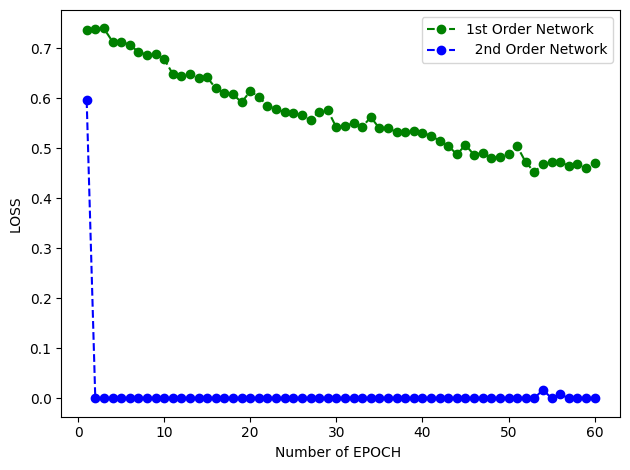

In [58]:
plt.plot(epoch_list,epoch_1_order , linestyle='--', marker='o',color='g')
plt.plot(epoch_list,epoch_2_order  , linestyle='--', marker='o',color='b')
plt.legend(['1st Order Network',  '  2nd Order Network'])
plt.xlabel('Number of EPOCH ')
plt.ylabel('LOSS ')
plt.tight_layout()
plt.show()


# PATTERNS USED (TARGETS) - HEATMAP PLOT
* It's 1.0 if the stimulus is over 0.5, and 0.0 otherwise

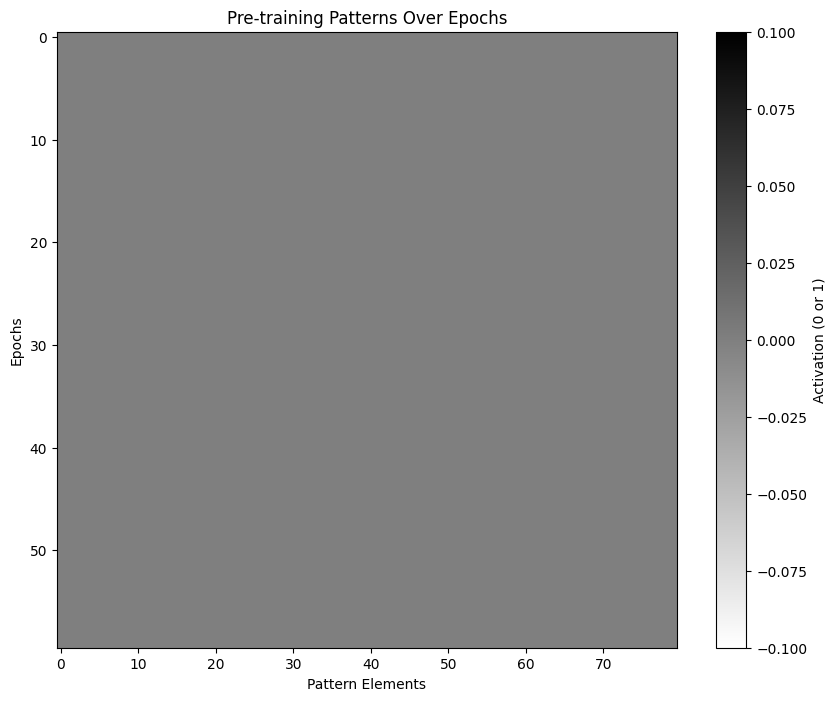

In [59]:
patterns_array = np.array(patterns_matrix)

plt.figure(figsize=(10, 8))
plt.imshow(patterns_array, cmap='binary', aspect='auto')
plt.xlabel('Pattern Elements')
plt.ylabel('Epochs')
plt.title('Pre-training Patterns Over Epochs')
plt.colorbar(label='Activation (0 or 1)')
plt.show()



# MODELS SAVING

In [60]:
PATH = './cnn1.pth'
PATH_2 = './cnn2.pth'

torch.save(first_order_network.state_dict(), PATH)
torch.save(second_order_network.state_dict(), PATH_2)



# MODEL LOADING FOR TRAINING AND SET UP OF THE 30 NETWORKS

In [61]:
num_networks=30
networks = []
for i in range(num_networks):
    loaded_model_trai = FirstOrderNetwork(Input_Size_1, Hidden_Size_1, Output_Size_1)
    loaded_model_2_trai = SecondOrderNetwork(Input_Size_2)

    loaded_model_trai.load_state_dict(torch.load(PATH))
    loaded_model_2_trai.load_state_dict(torch.load(PATH_2))

    loaded_model_trai.to(device)
    loaded_model_2_trai.to(device)

    criterion_1 = nn.MSELoss()
    criterion_2 = nn.MSELoss()

    optimizer_1 = optim.SGD(loaded_model_trai.parameters(), lr=learning_rate, momentum=momentum)
    optimizer_2 = optim.SGD(loaded_model_2_trai.parameters(), lr=learning_rate, momentum=momentum)

    networks.append([loaded_model_trai, loaded_model_2_trai , criterion_1 , criterion_2 , optimizer_1 , optimizer_2])



# TRAINING - HIGH CONSCIOUSNESS






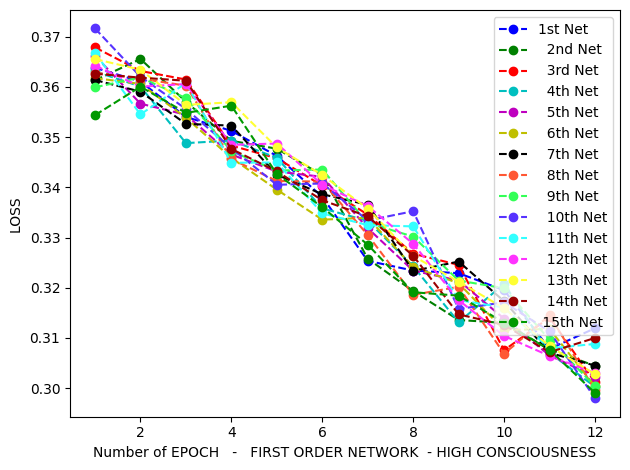

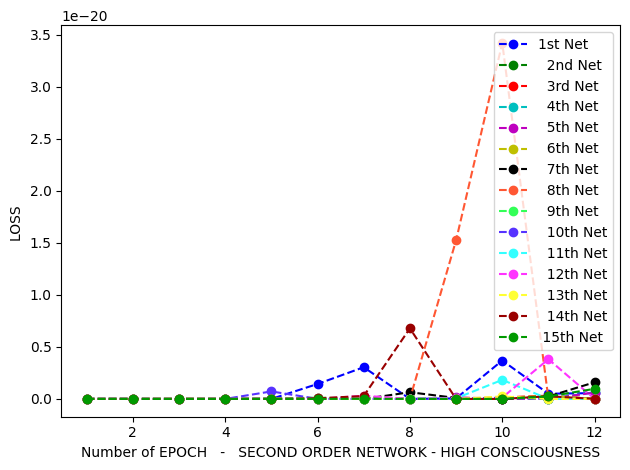

In [62]:
n_epochs_tra_1=12

epoch_list = list(range(1, n_epochs_tra_1 + 1))
epoch_1_order= np.zeros(( len(networks),n_epochs_tra_1))
epoch_2_order= np.zeros((  len(networks),n_epochs_tra_1))

for network in range( 0, 15):

  for epoch in range(n_epochs_tra_1):

    patterns_tensor = Array_Words(2, 45 )

    output_first_order = networks[network][0](patterns_tensor)
    output_second_order = networks[network][1](output_first_order - patterns_tensor)

    order_2_tensor = target_second(patterns_tensor , output_first_order)
    loss_1 = networks[network][2](   output_first_order  ,   patterns_tensor    )
    loss_2 = networks[network][3](   output_second_order  , order_2_tensor     )

    loss_2.backward(retain_graph=True)
    loss_1.backward()

    networks[network][5].step()
    networks[network][4].step()

    networks[network][5].zero_grad()
    networks[network][4].zero_grad()

    epoch_1_order[network][epoch] = loss_1
    epoch_2_order[network][epoch] = loss_2

for i in range(0,15):
  plt.plot(epoch_list,epoch_1_order[i] , linestyle='--', marker='o',color=colors[i])
plt.legend(['1st Net','  2nd Net','  3rd Net','  4th Net','  5th Net','  6th Net','  7th Net','  8th Net','  9th Net','  10th Net','  11th Net','  12th Net','  13th Net','  14th Net',' 15th Net'] , loc='upper right')
plt.xlabel('Number of EPOCH   -   FIRST ORDER NETWORK  - HIGH CONSCIOUSNESS')
plt.ylabel('LOSS ')
plt.tight_layout()
plt.show()


for i in range(0,15):
  plt.plot(epoch_list,epoch_2_order[i] , linestyle='--', marker='o',color=colors[i])
plt.legend(['1st Net','  2nd Net','  3rd Net','  4th Net','  5th Net','  6th Net','  7th Net','  8th Net','  9th Net','  10th Net','  11th Net','  12th Net','  13th Net','  14th Net',' 15th Net'] , loc='upper right')
plt.xlabel('Number of EPOCH   -   SECOND ORDER NETWORK - HIGH CONSCIOUSNESS')
plt.ylabel('LOSS ')
plt.tight_layout()
plt.show()



# TRAINING - LOW CONSCIOUSNESS


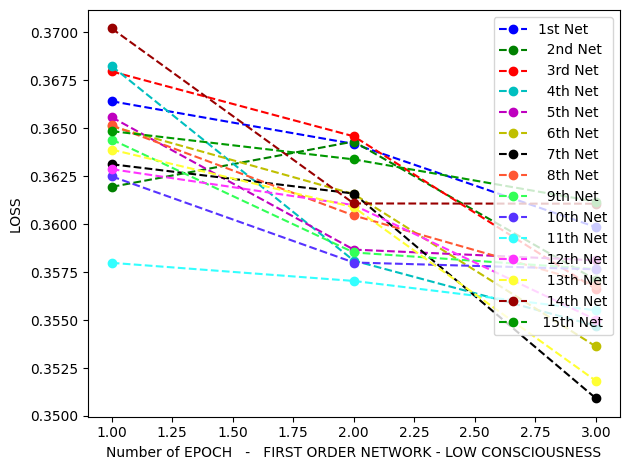

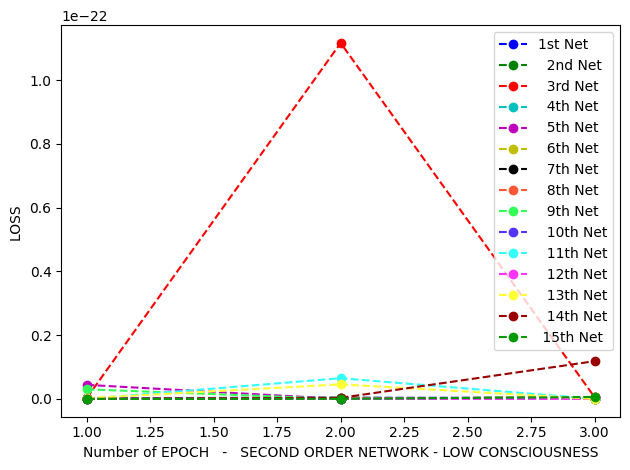

In [63]:
n_epochs_tra_2= 3

epoch_list = list(range(1, n_epochs_tra_2 + 1))
epoch_1_order= np.zeros(( len(networks),n_epochs_tra_2))
epoch_2_order= np.zeros((  len(networks),n_epochs_tra_2))

for network in range( 15, 30):

  for epoch in range(n_epochs_tra_2):

    patterns_tensor = Array_Words(2, 45 )

    output_first_order = networks[network][0](patterns_tensor)
    output_second_order = networks[network][1](output_first_order - patterns_tensor)

    order_2_tensor = target_second(patterns_tensor , output_first_order)
    loss_1 = networks[network][2](   output_first_order  ,   patterns_tensor    )
    loss_2 = networks[network][3](   output_second_order  , order_2_tensor     )

    loss_2.backward(retain_graph=True)
    loss_1.backward()

    networks[network][5].step()
    networks[network][4].step()

    networks[network][5].zero_grad()
    networks[network][4].zero_grad()

    epoch_1_order[network][epoch] = loss_1
    epoch_2_order[network][epoch] = loss_2

for i in range(15,30):
  plt.plot(epoch_list,epoch_1_order[i] , linestyle='--', marker='o',color=colors[i-15])
plt.legend(['1st Net','  2nd Net','  3rd Net','  4th Net','  5th Net','  6th Net','  7th Net','  8th Net','  9th Net','  10th Net','  11th Net','  12th Net','  13th Net','  14th Net',' 15th Net'] , loc='upper right')
plt.xlabel('Number of EPOCH   -   FIRST ORDER NETWORK - LOW CONSCIOUSNESS')
plt.ylabel('LOSS ')
plt.tight_layout()
plt.show()


for i in range(15,30):
  plt.plot(epoch_list,epoch_2_order[i] , linestyle='--', marker='o',color=colors[i-15])
plt.legend(['1st Net','  2nd Net','  3rd Net','  4th Net','  5th Net','  6th Net','  7th Net','  8th Net','  9th Net','  10th Net','  11th Net','  12th Net','  13th Net','  14th Net',' 15th Net'] , loc='upper right')
plt.xlabel('Number of EPOCH   -   SECOND ORDER NETWORK - LOW CONSCIOUSNESS')
plt.ylabel('LOSS ')
plt.tight_layout()
plt.show()


# MODEL LOADING AND PREPARISSON FOR EVALUATION

In [64]:
Testing_grammar_A= Array_Words(2, 30 )
Testing_grammar_B= Array_Words(3, 30 )

Testing_patterns= np.concatenate((Testing_grammar_A, Testing_grammar_A))
Testing_patterns= torch.Tensor(Testing_patterns).to(device)

for network in range(len(networks)):
  networks[network][0].eval()
  networks[network][1].eval()


# TESTING LOOP

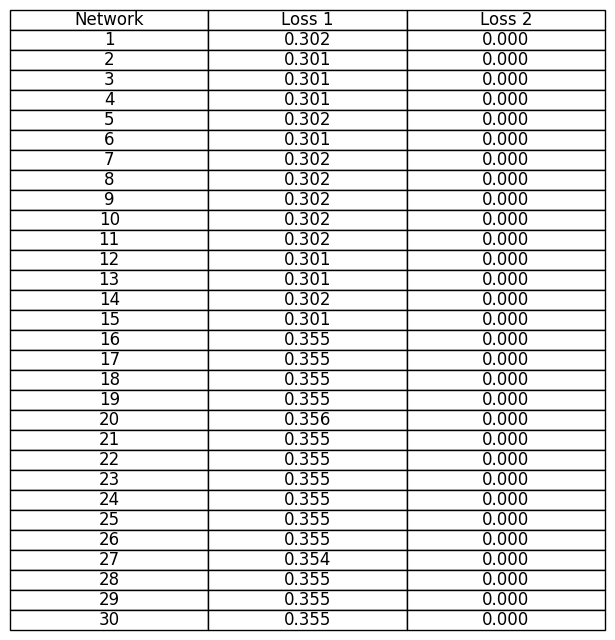

In [65]:

numbers_networks = list(range(1, 31))
loss_1_networks= np.zeros(30)
loss_2_networks= np.zeros(30)

for network in range(len(networks)):


  with torch.no_grad():

    patterns_tensor= Testing_patterns

    output_first_order = networks[network][0](patterns_tensor)
    output_second_order = networks[network][1](output_first_order - patterns_tensor)

    order_2_tensor = target_second(patterns_tensor , output_first_order)

    loss_1 = networks[network][2](   output_first_order  ,   patterns_tensor    )
    loss_2 = networks[network][3](   output_second_order  , order_2_tensor     )


    loss_1_networks[network] = loss_1
    loss_2_networks[network] = loss_2



fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table_data = []
for number, loss_1, loss_2 in zip(numbers_networks, loss_1_networks, loss_2_networks):
    table_data.append([number, f'{loss_1:.3f}', f'{loss_2:.3f}'])

table = ax.table(cellText=table_data, colLabels=['Network', 'Loss 1', 'Loss 2'], cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.show()




In [ ]:
''